Kullanılan Cihaz: cuda
Tahmin yapılıyor...
Tespit edilen nesne sayısı: 5
Nesneler: ['person', 'person', 'dining table', 'laptop', 'scissors']


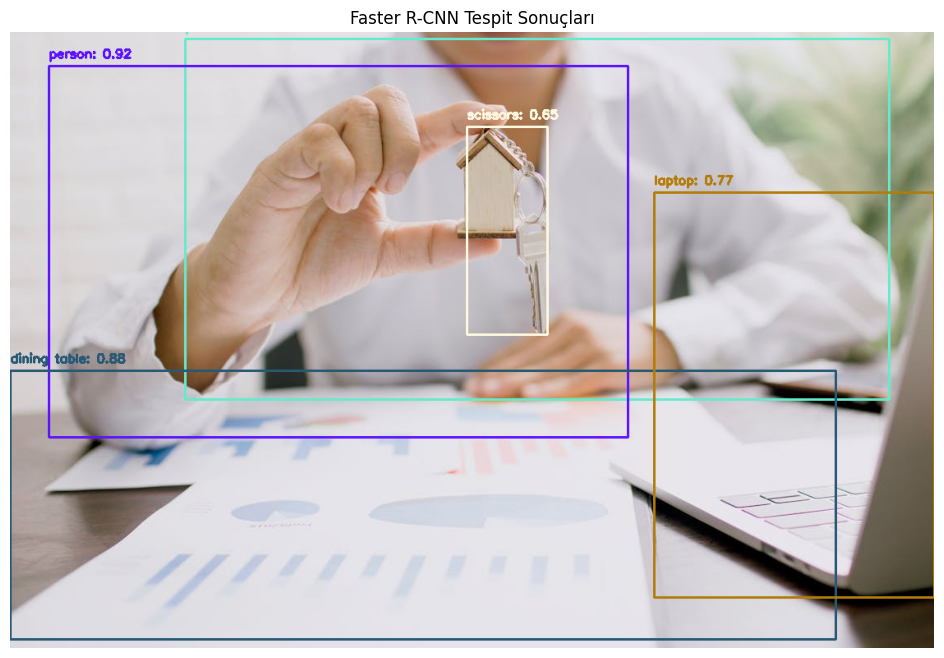

In [3]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# --- 1. Ayarlar ve Cihaz Seçimi ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılan Cihaz: {device}")

# --- 2. Modeli Yükleme ---
# COCO veri setinde eğitilmiş ağırlıkları yüklüyoruz.
# Bu model 91 farklı nesne sınıfını tanıyabilir.
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)
model.to(device)
model.eval() # Modeli değerlendirme moduna al (Dropout vb. kapatır)

# --- 3. COCO Sınıf İsimleri ---
# Modelin çıktı verdiği sayıların (index) karşılık geldiği isimler
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# --- 4. Görüntü İşleme ve Tahmin Fonksiyonu ---
def get_prediction(img_path, threshold=0.5):
    """
    Görüntüyü alır, modele verir ve belirli bir güven skorunun (threshold)
    üzerindeki tahminleri döndürür.
    """
    # Görüntüyü yükle
    if img_path.startswith('http'):
        response = requests.get(img_path)
        img = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        img = Image.open(img_path).convert("RGB")
        
    # Tensöre çevir
    transform = transforms.Compose([transforms.ToTensor()])
    img_tensor = transform(img).to(device)
    
    # Modele ver (Batch boyutu ekleyerek: [1, C, H, W])
    with torch.no_grad():
        pred = model([img_tensor]) # Liste içinde verilir

    # Tahminleri ayrıştır
    # pred[0] sözlük döner: 'boxes', 'labels', 'scores'
    pred_scores = pred[0]['scores'].detach().cpu().numpy()
    
    # Eşik değerinden yüksek skorlu olanların indekslerini bul
    # (Alternatif ve daha hızlı yöntem: maskeleme)
    keep_indices = pred_scores > threshold
    
    pred_boxes = pred[0]['boxes'].detach().cpu().numpy()[keep_indices]
    pred_class_indices = pred[0]['labels'].detach().cpu().numpy()[keep_indices]
    pred_class_names = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in pred_class_indices]
    pred_final_scores = pred_scores[keep_indices]

    return img, pred_boxes, pred_class_names, pred_final_scores

# --- 5. Görselleştirme Fonksiyonu ---
def plot_result(img, boxes, classes, scores):
    """
    Orijinal görüntü üzerine kutuları ve etiketleri çizer.
    """
    # PIL Image -> OpenCV formatına (numpy array) çevir
    img_cv = np.array(img)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)
    
    for i in range(len(boxes)):
        # Kutunun koordinatları
        box = boxes[i]
        x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        
        # Rastgele bir renk seç
        color = np.random.uniform(0, 255, size=(3,))
        
        # Kutuyu çiz
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), color, 2)
        
        # Etiketi yaz
        label = f"{classes[i]}: {scores[i]:.2f}"
        cv2.putText(img_cv, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
    # BGR -> RGB (Matplotlib için)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Faster R-CNN Tespit Sonuçları")
    plt.show()

# --- 6. Uygulama ---

# Örnek bir resim URL'si (İçinde insan, araba vb. olan)
img_url = "https://images.pexels.com/photos/4161619/pexels-photo-4161619.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
# Alternatif: Yerel dosya yolu da verebilirsiniz "resim.jpg"

print("Tahmin yapılıyor...")
img, boxes, classes, scores = get_prediction(img_url, threshold=0.5)

print(f"Tespit edilen nesne sayısı: {len(boxes)}")
print("Nesneler:", classes)

plot_result(img, boxes, classes, scores)